# <center><code font-size=30px; style="background:Pink;color:Black">X-Ray Pneumonia using CNN</code><center>
<center>
    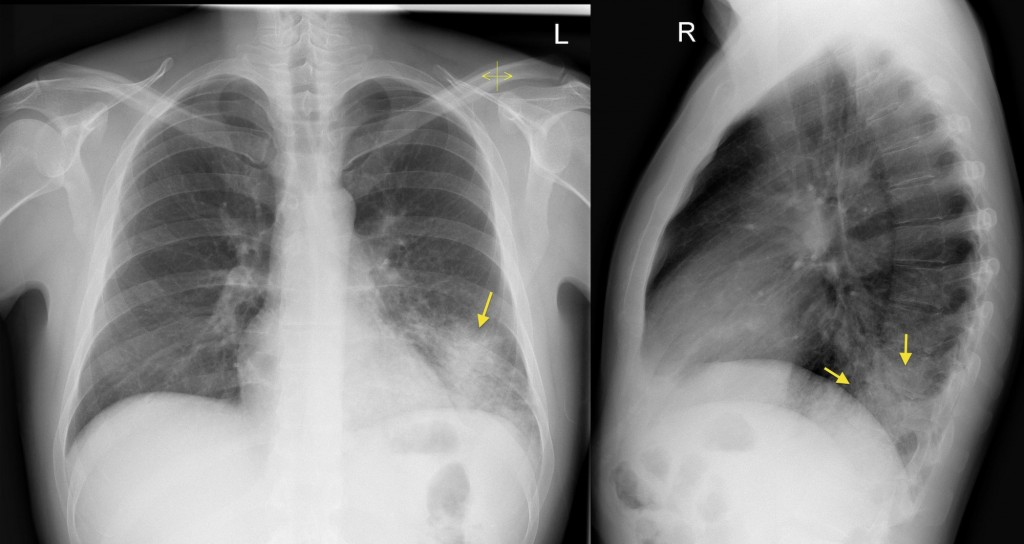
</center>


# 1- Building a CNN model using `sigmoid` as the last layer's activation function, using only **Label Encoding**

- Note:
 Other versions of this notebook with different model structures `WITHOUT` data augmentation can be viewed here: https://github.com/reemmuharram/Pneumonia-Chest-X-Ray-CNN

## 1.1- Libraries

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

import os

#EDA
import matplotlib.pyplot as plt
import plotly_express as px
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#Label encoding
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

#Data reading
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#CNN
from tensorflow.keras import layers, models, utils
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings('ignore')

## 1.2- Prepare data directories

In [2]:
main_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(main_dir, 'train')
valid_dir = os.path.join(main_dir, 'val')
test_dir = os.path.join(main_dir, 'test')

In [3]:
def folders(dir):
    penumonia = os.path.join(dir, 'PNEUMONIA')
    normal = os.path.join(dir, 'NORMAL')
    return normal, penumonia

In [4]:
normal_train, pneumonia_train = folders(train_dir)
normal_valid, pneumonia_valid = folders(valid_dir)
normal_test,pneumonia_test = folders(test_dir)

## 1.3- Data Distribution

In [5]:
train_normal = len(os.listdir(normal_train))
train_pneumonia = len(os.listdir(pneumonia_train))

valid_normal = len(os.listdir(normal_valid))
valid_pneumonia = len(os.listdir(pneumonia_valid))

test_normal = len(os.listdir(normal_test))
test_pneumonia = len(os.listdir(pneumonia_test))

In [6]:
print("Number of NORMAL X-Rays in the train dataset =", train_normal)
print("Number of PNEUMONIA X-Rays in the train dataset =", train_pneumonia)
print("-"*60)

print("Number of NORMAL X-Rays in the valid dataset =", valid_normal)
print("Number of PNEUMONIA X-Rays in the valid dataset =", valid_pneumonia)
print("-"*60)

print("Number of NORMAL X-Rays in the test dataset =", test_normal)
print("Number of PNEUMONIA X-Rays in the test dataset =", test_pneumonia)
print("-"*60)


#Plot the nmber of images in each dataset
data = {'Train' : [train_pneumonia, train_normal],
       'Validation' : [valid_pneumonia, valid_normal],
       'Test' : [test_pneumonia, test_normal]}


df = pd.DataFrame(data, index = ['PNEUMONIA', 'NORMAL'])
fig = px.bar(df, x = data, color_discrete_sequence=["darkred", "darkblue", "darkgreen"])

fig.update_layout(title = 'Count of images in Train, Test and Validation sets',
                 xaxis_title = "Count",
                 yaxis_title = "X-Ray result",
                 height = 900, width = 900)
fig.show()

Number of NORMAL X-Rays in the train dataset = 1341
Number of PNEUMONIA X-Rays in the train dataset = 3875
------------------------------------------------------------
Number of NORMAL X-Rays in the valid dataset = 8
Number of PNEUMONIA X-Rays in the valid dataset = 8
------------------------------------------------------------
Number of NORMAL X-Rays in the test dataset = 234
Number of PNEUMONIA X-Rays in the test dataset = 390
------------------------------------------------------------


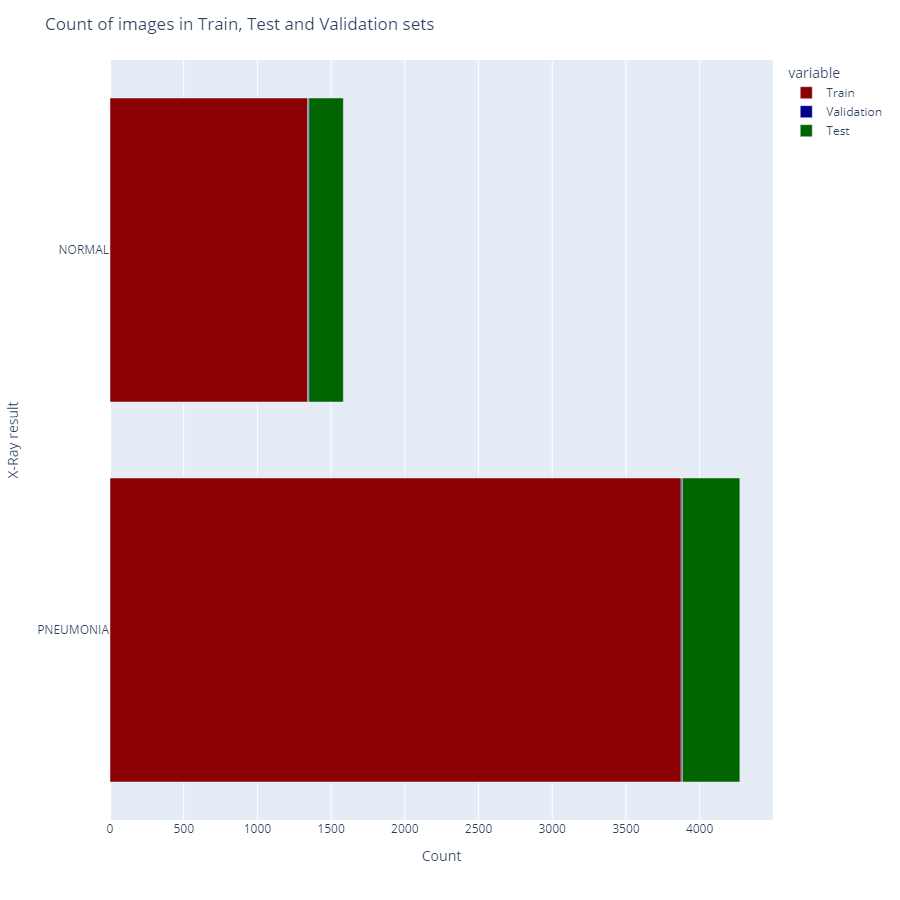

## 1.4- Data Splititng

* In this section the data will be re-splitted into training data and validation data to fix the data distribution issue in the original dataset 
* While resplitting only the training data will be used, therefore the validation data of the original dataset will replace the test dataset, making the data splitted by `20%` for **validation** and `20%` for the **test** which makes more sense.

In [7]:
img_size = (224, 224)
batch_size = 64


train_data = image_dataset_from_directory(train_dir,
    image_size=img_size, batch_size=batch_size, validation_split=0.2, subset='training', seed=42)

validation_data = image_dataset_from_directory(train_dir,
    image_size=img_size, batch_size=batch_size, validation_split=0.2, subset='validation', seed=42)

test_data = image_dataset_from_directory(test_dir, image_size = img_size, batch_size = batch_size)

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


## 1.5- Data Exploration

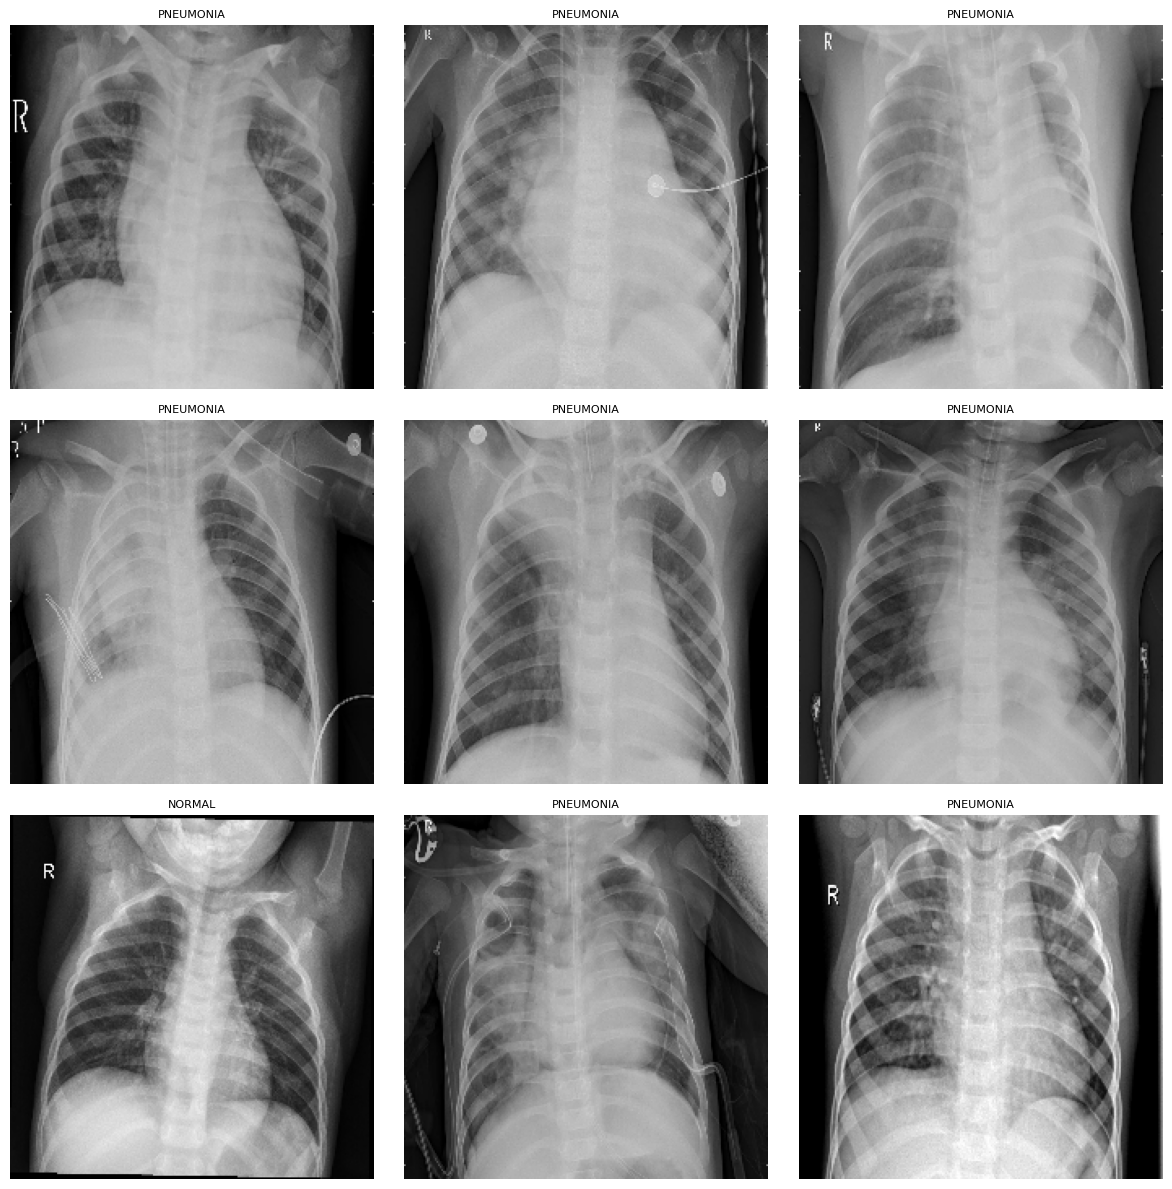

In [8]:
plt.figure(figsize=(12, 12))

for images, labels in train_data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(train_data.class_names[labels[i]], fontsize = 8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

## 1.6- Data Preprocessing & Augmentation
* In this section, since **data augmentation** is only applied to the ***train dataset***, while data **normalization and image resizing** will be applied to the ***whole dataset***, `2` similar functions were implemented for this cause, one that applies data augmentation and normalization, and the other one only applies normalization

In [9]:
def train_preprocessing(dataset):
    img_list = []
    label_list = []

    for images, labels in dataset:
        for img in images:
            #data augmentation
            img = tf.image.random_flip_left_right(img)  
            img = tf.image.random_flip_up_down(img)  
            
            img = img.numpy()
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.resize(img, (224, 224))
            img = img / 255.0  # Normalize the image

            img_list.append(img)
        
        for label in labels:
            label_list.append(label.numpy())  # Convert label tensor to numpy and append

    return np.array(img_list), np.array(label_list)


In [10]:
def val_test_preprocessing(dataset):
    img_list = []
    label_list = []

    for images, labels in dataset:
        for img in images:
            img = img.numpy() 
            img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
            img = cv2.resize(img, (224, 224))
            img = img / 255.0  # Normalize the image

            img_list.append(img)
        
        for label in labels:
            label_list.append(label.numpy())  # Convert label tensor to numpy and append

    return np.array(img_list), np.array(label_list)


In [11]:
train_prep = train_preprocessing(train_data)

In [12]:
valid_prep = val_test_preprocessing(validation_data)
test_prep = val_test_preprocessing(test_data)

## 1.7- Labels encoding 

In [13]:
train_imgs = train_prep[0]
valid_imgs = valid_prep[0]
test_imgs = test_prep[0]

In [14]:
#label encoding
enc = LabelEncoder()

train_labels = enc.fit_transform(train_prep[1])
valid_labels = enc.fit_transform(valid_prep[1])
test_labels = enc.fit_transform(test_prep[1])

In [15]:
#check for preprocessed images and labels
print("Number of preprocessed images =", len(train_imgs))
print("Number of preprocessed labels =", len(train_labels))
print("-"*40)

print("Number of preprocessed images =", len(valid_imgs))
print("Number of preprocessed labels =", len(valid_labels))
print("-"*40)

print("Number of preprocessed images =", len(test_imgs))
print("Number of preprocessed labels =", len(test_labels))

Number of preprocessed images = 4173
Number of preprocessed labels = 4173
----------------------------------------
Number of preprocessed images = 1043
Number of preprocessed labels = 1043
----------------------------------------
Number of preprocessed images = 624
Number of preprocessed labels = 624


## 1.8- Build Model

In [71]:
input_shape = (224, 224, 1)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 112x112
model.add(BatchNormalization())

#conv b1
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same', input_shape=input_shape))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(MaxPool2D(2, 2)) #reduces to 56x56
model.add(BatchNormalization())

#conv b2
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(MaxPool2D(2, 2)) #reduces to 28x28
model.add(BatchNormalization())

#conv b4
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(MaxPool2D(2, 2)) #reduces to 14x14
model.add(BatchNormalization())
model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(BatchNormalization())

model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_66 (Conv2D)              │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_29 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_69 (Conv2D)              │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_30 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_32          │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_70 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_71 (Conv2D)              │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_31 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_72 (Conv2D)              │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_73 (Conv2D)              │ (None, 28, 28, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 14, 14, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_7 (Flatten)             │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 32)             │         2,08

 Total params: 14,062,305 (53.64 MB)

 Trainable params: 14,061,281 (53.64 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [74]:
lr = 1e-3
epochs = 15 
batchsize = 16
history = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.BinaryCrossentropy,
              metrics=['accuracy'])

In [75]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=4)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=2, verbose=2, min_lr=1e-5)

## 1.9- Model Training 

In [76]:
history = model.fit(train_imgs, train_labels, validation_data=(valid_imgs, valid_labels), epochs = epochs, batch_size=batchsize,
                   callbacks = [early_stopping, reduce_lr])

Epoch 1/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 53s 140ms/step - accuracy: 0.8762 - loss: 0.3397 - val_accuracy: 0.7613 - val_loss: 1.0229 - learning_rate: 0.0010
Epoch 2/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9385 - loss: 0.1881 - val_accuracy: 0.7613 - val_loss: 1.6158 - learning_rate: 0.0010
Epoch 3/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9393 - loss: 0.1576 - val_accuracy: 0.8974 - val_loss: 0.2783 - learning_rate: 0.0010
Epoch 4/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9596 - loss: 0.1226 - val_accuracy: 0.5820 - val_loss: 1.1190 - learning_rate: 0.0010
Epoch 5/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9633 - loss: 0.1060
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9633 - loss: 0.1060 - val_accuracy: 0.8351 - val_loss: 0.4590 - learning_rate: 0.0010
Epoch 6/15
261/261 ━━━━━━━━━━━━━━━━━━━━ 21s 82ms/step - accuracy: 0.9776 - l

## 1.10- Model Evaluation

In [77]:
loss, acc = model.evaluate(valid_imgs, valid_labels)
print("Validation Loss = ", loss)
print("Validation Accuracy = ", acc*100, "%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - accuracy: 0.8877 - loss: 0.4129
Validation Loss =  0.41603899002075195
Validation Accuracy =  88.68648409843445 %


In [78]:
loss, acc = model.evaluate(test_imgs, test_labels)
print("Test Loss = ", loss)
print("Test Accuracy = ", acc*100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8671 - loss: 0.7081
Test Loss =  0.8084540963172913
Test Accuracy =  83.97436141967773 %


## 1.11- Learning Curves

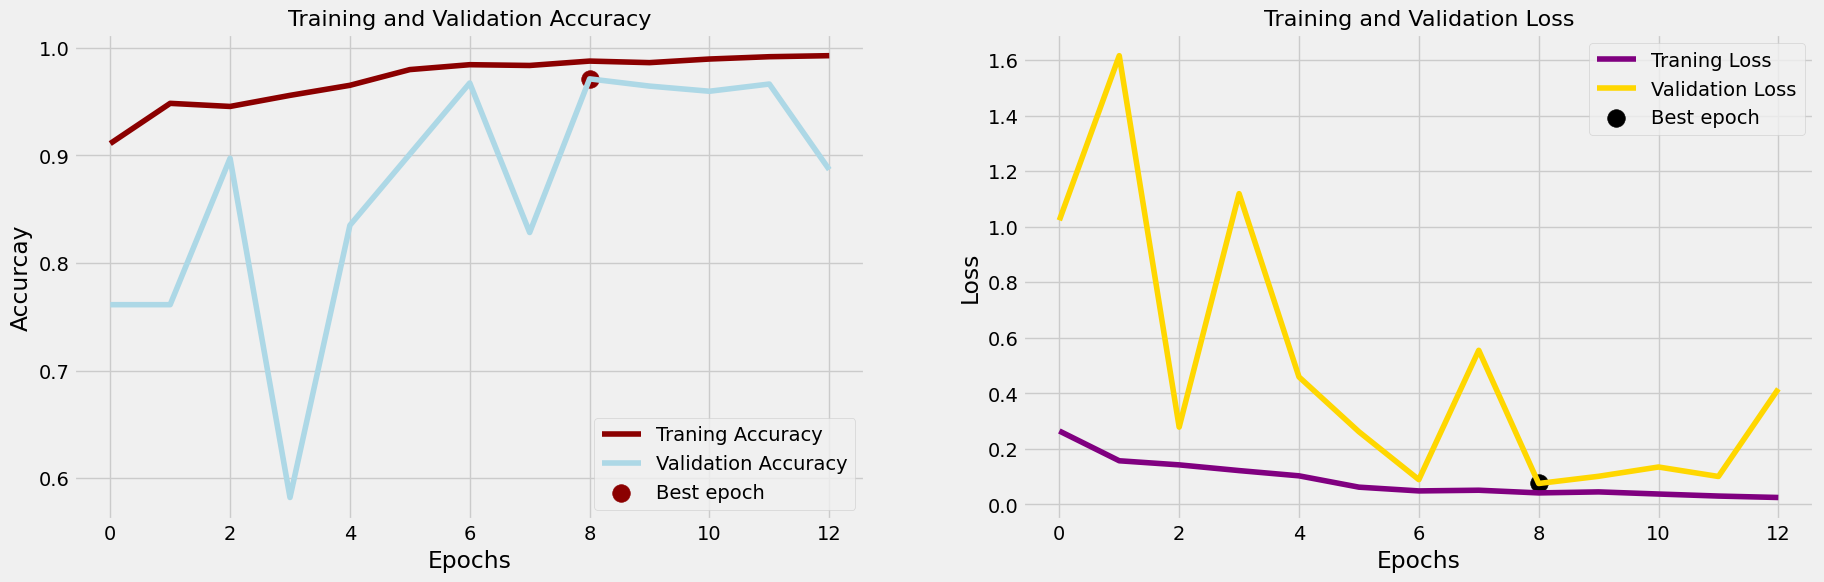

In [79]:
#train history
train_acc = history.history['accuracy']
train_loss = history.history['loss']

#validatioin history
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

min_loss = np.argmin(val_loss) # get min val loss epoch #
val_lowest = val_loss[min_loss]

max_acc = np.argmax(val_acc) #get max val acc epoch #
val_max = val_acc[max_acc]

epochs_ = [i for i in range(len(train_acc))]

#Plot Style
plt.figure(figsize = (20,6))
plt.style.use('fivethirtyeight')

#Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_, train_acc, 'darkred', label = "Traning Accuracy")
plt.plot(epochs_, val_acc, 'lightblue', label = "Validation Accuracy")
plt.scatter(max_acc, val_max, s = 160, c = "darkred", label = "Best epoch")

plt.title("Training and Validation Accuracy", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Accurcay")
plt.legend()

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_, train_loss, 'purple', label = "Traning Loss")
plt.plot(epochs_, val_loss, 'gold', label = "Validation Loss")
plt.scatter(min_loss, val_lowest, s = 160, c = "black", label = "Best epoch")

plt.title("Training and Validation Loss", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 1.12- Classification Report

In [80]:
preds = model.predict(test_imgs)

threshold = 0.5
pred_labels = (preds >= threshold).astype(int)
true_labels = test_labels

cr = classification_report(true_labels, pred_labels, target_names=['NORMAL', 'PNEUMONIA'])
print(cr)


20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step
              precision    recall  f1-score   support

      NORMAL       0.88      0.67      0.76       234
   PNEUMONIA       0.83      0.94      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.81      0.82       624
weighted avg       0.84      0.84      0.83       624



## 1.13- Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

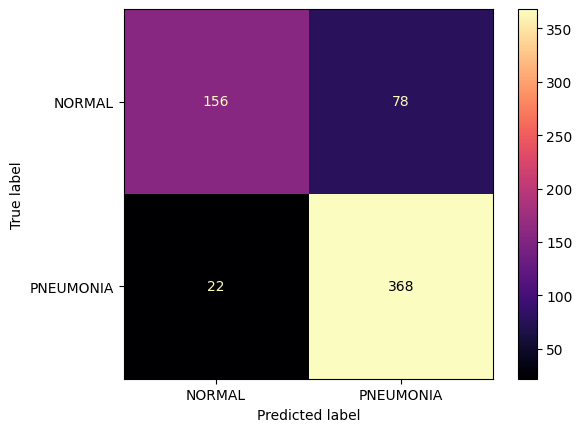

In [81]:
plt.style.use('default')
cm = confusion_matrix(true_labels, pred_labels)
disp_cm = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['NORMAL', 'PNEUMONIA'])
plt.figure(figsize=(10, 10))
disp_cm.plot(cmap='magma')
plt.show()

# **1.14- Result Analysis**

## Result Analysis
### 1- Normal Class:
- 0.88 Precision: The model predicts **Normal** class correctly `88%` of the time so the model is highly accurate when it predicts normal X-Rays meaning there is fewer False Positives
- 0.67 recall: Indicates that the model correctly identifies only `67%` of the **actual Normal** X-Rays so it misses a large number of the normal X-Rays

### 2- Pneumonia Class:
- 0.83 Precision: The model has relatively more False Positives, and `83%` of the time, predicts **Pneumonia** X-Rays correctly
- 0.94 Recall: Indicates that the model correctly identifies `94%` actual Pnuemonia X-Rays which means the model is good at identifying the **Pneumonia** X-Rays and misses only a few

## Implications of the model's accuracy:
### 1- Data Imbalance:
- The data is highly imbalanced, it has way more images of` Pneumonia X-Rays` which could lead to overfitting
- It leads to the model predicting **Pnuemonia** classes very well while struggling with predicting **Normal** X-Rays

### 2- High Precision and Low Recall for **Normal** Class:
- The model is very confident while predicting **Normal** Class, therefore the Precision score is `88%`
- The model struggles to predict **Normal** X-Rays as it predicts only `67%` of the actual Normal cases

### 3- High Recall and low Precision for **Pneumonia class**:
- The model not as confident confident while predicting **Pneumonia** Class, therefore the Precision score is `0.83`
- The model does a very good job predicting **Pneumonia** X-Rays as it predicts only `94%` of the actual Pneumonia cases

### 4- Impact on medical use:
- The **low recall** score in the Normal class would lead to **misdiagnosis** for many healthy patients and possible mistreatment
- The **high recall** score in the Pnuemonia class will lead to **rarely** missing any actual sick patients

## Areas of potential improvement:

### 1- Imbalance handling: 
- Increase the number of images in the **Normal** Class, which can help the model see more images that are normal to avoid `overfitting` and increase the model's `accuracy` while predicrting this class

### 2- Increase number of images in the dataset: 
- Some images might be a bit cofusing for a human being so the more images are seen, the better it is to be understood, and same thing goes for the model, a bigger dataset would help avoid overfitiing, get better validation and test accuracy and better model scores in terms of `Precision` and `Recall`

### 3- Using pre-trained models as a base mode:
- Pre-trained models tend to show better results than **CNNs** by itself, so using a **pre-trained model** as a `base model` could give better results with a relatively small datase

# 2- Building a CNN model using `softmax` as the activation function of the output layer, applying **One-Hot Encoding**

## 2.1- One-Hot Encoding

In [109]:
#one-hot enc
train_enc = to_categorical(train_labels, num_classes=2)
valid_enc = to_categorical(valid_labels, num_classes=2)
test_enc = to_categorical(test_labels, num_classes=2)

In [110]:
#check encoded labels
print("Number of encoded labels =", len(train_enc))
print("-"*40)
print("Number of encoded labels =", len(valid_enc))
print("-"*40)
print("Number of encoded labels =", len(test_enc))

Number of encoded labels = 4173
----------------------------------------
Number of encoded labels = 1043
----------------------------------------
Number of encoded labels = 624


## 2.2 Build Model
- The model structure for this part is different from the previou one as this got way better results

In [111]:
input_shape = (224, 224, 1)
model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(32, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 112x112

#conv b1
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(64, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 56x56

#conv b2
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 28x28

model.add(Conv2D(128, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 28x28

model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 14x14

model.add(Conv2D(256, kernel_size=(3, 3), strides=1, padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(2, 2)) #reduces to 7x7


model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_104 (Conv2D)             │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_105 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_106 (Conv2D)             │ (None, 224, 224, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_47 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_107 (Conv2D)             │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_108 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_109 (Conv2D)             │ (None, 112, 112, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_48 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_110 (Conv2D)             │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_111 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_112 (Conv2D)             │ (None, 56, 56, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_49 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_113 (Conv2D)             │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 28, 28, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_50 (MaxPooling2D) │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_114 (Conv2D)             │ (None, 14, 14, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_115 (Conv2D)             │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_116 (Conv2D)             │ (None, 14, 14, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 14, 14, 256)    │             

 Total params: 3,328,002 (12.70 MB)

 Trainable params: 3,326,274 (12.69 MB)

 Non-trainable params: 1,728 (6.75 KB)

In [112]:
lr = 1e-3
epochs = 20
batchsize = 16
history = model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=tf.losses.BinaryCrossentropy,
              metrics=['accuracy'])

## 2.3 Model Training

In [113]:
history2 = model.fit(train_imgs, train_enc, validation_data=(valid_imgs, valid_enc), epochs = epochs, batch_size=batchsize,
                   callbacks = [early_stopping, reduce_lr])

Epoch 1/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 55s 159ms/step - accuracy: 0.8414 - loss: 0.3634 - val_accuracy: 0.7747 - val_loss: 1.3431 - learning_rate: 0.0010
Epoch 2/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 33s 127ms/step - accuracy: 0.9297 - loss: 0.1860 - val_accuracy: 0.6347 - val_loss: 1.9187 - learning_rate: 0.0010
Epoch 3/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.9346 - loss: 0.1864 - val_accuracy: 0.9597 - val_loss: 0.1248 - learning_rate: 0.0010
Epoch 4/20
261/261 ━━━━━━━━━━━━━━━━━━━━ 33s 125ms/step - accuracy: 0.9483 - loss: 0.1517 - val_accuracy: 0.8178 - val_loss: 0.4474 - learning_rate: 0.0010


## 2.4- Model Evaluation

In [114]:
loss, acc = model.evaluate(valid_imgs, valid_enc)
print("Validation Loss = ", loss)
print("Validation Accuracy = ", acc*100, "%")

33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.8079 - loss: 0.4699
Validation Loss =  0.4474446177482605
Validation Accuracy =  81.78331851959229 %


In [115]:
loss, acc = model.evaluate(test_imgs, test_enc)
print("Test Loss = ", loss)
print("Test Accuracy = ", acc*100, "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - accuracy: 0.8549 - loss: 0.4649
Test Loss =  0.44010359048843384
Test Accuracy =  86.21794581413269 %


## 2.5- Learning Curves

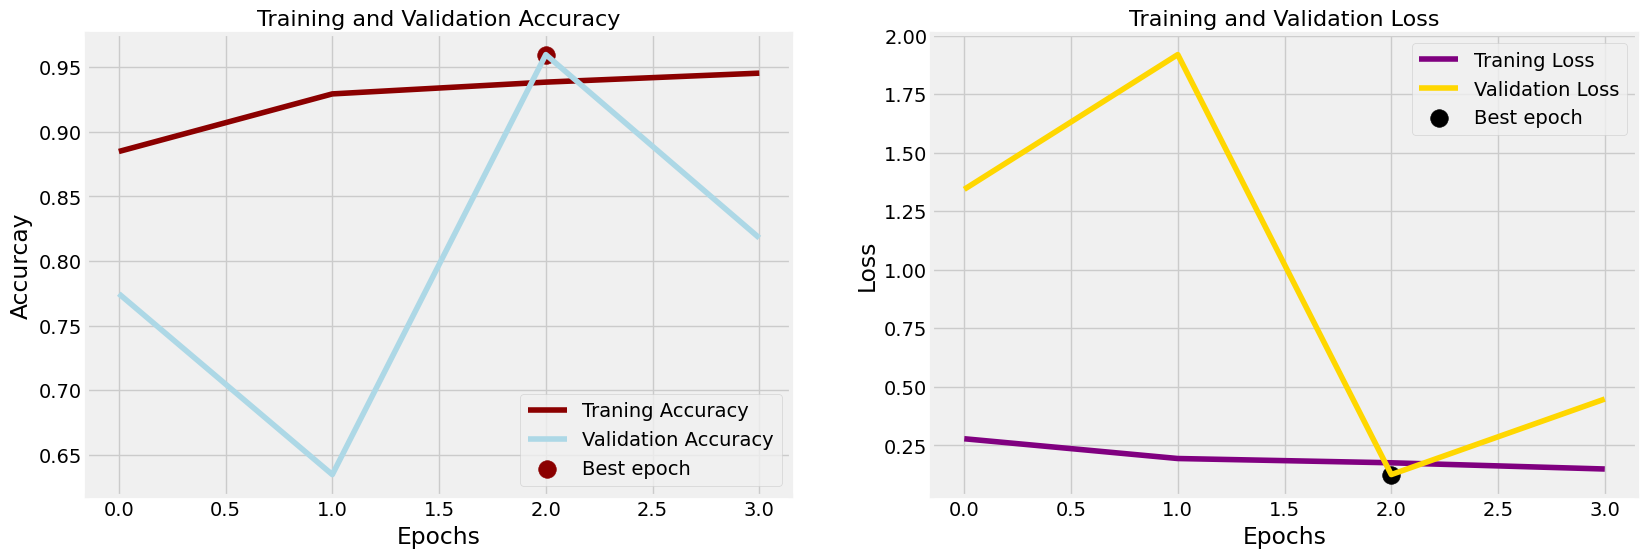

In [116]:
#train history
train_acc = history2.history['accuracy']
train_loss = history2.history['loss']

#validatioin history
val_acc = history2.history['val_accuracy']
val_loss = history2.history['val_loss']

min_loss = np.argmin(val_loss) # get min val loss epoch #
val_lowest = val_loss[min_loss]

max_acc = np.argmax(val_acc) #get max val acc epoch #
val_max = val_acc[max_acc]

epochs_ = [i for i in range(len(train_acc))]

#Plot Style
plt.figure(figsize = (20,6))
plt.style.use('fivethirtyeight')

#Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_, train_acc, 'darkred', label = "Traning Accuracy")
plt.plot(epochs_, val_acc, 'lightblue', label = "Validation Accuracy")
plt.scatter(max_acc, val_max, s = 160, c = "darkred", label = "Best epoch")

plt.title("Training and Validation Accuracy", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Accurcay")
plt.legend()

#Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_, train_loss, 'purple', label = "Traning Loss")
plt.plot(epochs_, val_loss, 'gold', label = "Validation Loss")
plt.scatter(min_loss, val_lowest, s = 160, c = "black", label = "Best epoch")

plt.title("Training and Validation Loss", fontsize = 16)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

## 2.6- Classification Report

In [117]:
preds = model.predict(test_imgs)
label_preds = np.argmax(preds, axis = 1)
true_labels = np.argmax(test_enc, axis = 1)
cr = classification_report(true_labels, label_preds, target_names=['NORMAL', 'PNEUMONIA'])
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step
              precision    recall  f1-score   support

      NORMAL       0.82      0.82      0.82       234
   PNEUMONIA       0.89      0.89      0.89       390

    accuracy                           0.86       624
   macro avg       0.85      0.85      0.85       624
weighted avg       0.86      0.86      0.86       624



## 2.7- Confusion Matrix

<Figure size 1000x1000 with 0 Axes>

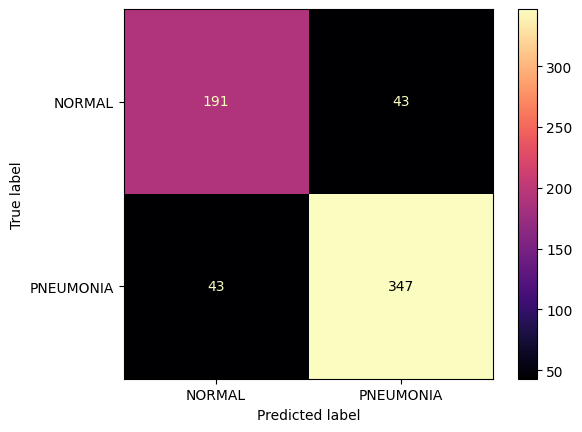

In [118]:
plt.style.use('default')
cm = confusion_matrix(true_labels, label_preds)
disp_cm = ConfusionMatrixDisplay(cm, display_labels=['NORMAL', 'PNEUMONIA'])
plt.figure(figsize=(10, 10))
disp_cm.plot(cmap='magma')
plt.show()

## 2.8- Result Analysis
### 1- Normal Class:
- 0.88 Precision: The model predicts **Normal** class correctly `82%` of the time so the model is highly accurate when it predicts normal X-Rays meaning there is fewer False Positives
- 0.67 recall: Indicates that the model correctly identifies only `82%` of the **actual Normal** X-Rays so it misses a fair number of the normal X-Rays compared to other previously implemented models

### 2- Pneumonia Class:
- 0.83 Precision: The model has relatively more False Positives, and `89%` of the time, predicts **Pneumonia** X-Rays correctly
- 0.94 Recall: Indicates that the model correctly identifies `89%` actual Pnuemonia X-Rays which means the model is good at identifying the **Pneumonia** X-Rays and misses a fair amount.

## Implications of the model's accuracy:
### 1- Data Imbalance:
- The data is highly imbalanced, it has way more images of` Pneumonia X-Rays` which could lead to overfitting
- It leads to the model predicting **Pnuemonia** classes very well while struggling with predicting **Normal** X-Rays

### 2- Relatively low Precision and Recall for **Normal** Class:
- Both `Precision` and `Recall` are relatively low for a medical-images-classification task for the **Normal** class

### 3- Low Precision and Recall for **Pneumonia class**:
- Both `Precision` and `Recall` are relatively low for a medical-images-classification task for the **Pneumonia** class

### 4- Impact on medical use:
- Low `Recall` for both classes lead to **misdiagnosis** for many healthy patients which leads to possible **mistreatment**

## Areas of potential improvement:

### 1- Imbalance handling: 
- Increase the number of images in the **Normal** Class, which can help the model see more images that are normal to avoid `overfitting` and increase the model's `accuracy` while predicrting this class

### 2- Increase number of images in the dataset: 
- Some images might be a bit cofusing for a human being so the more images are seen, the better it is to be understood, and same thing goes for the model, a bigger dataset would help avoid overfitiing, get better validation and test accuracy and better model scores in terms of `Precision` and `Recall`

### 3- Using pre-trained models as a base mode:
- Pre-trained models tend to show better results than **CNNs** by itself, so using a **pre-trained model** as a `base model` could give better results with a relatively small datase